# Updating Microstate Files

This jupyter notebook incorporates corrections to enumerated microstates files. I will also add canonical SMILES column to enumerated microstates files, in addition to canonical isomeric SMILES.

Updated microstate list files to be created for 24 molecules (v1_4_2):  
* `SMX_microstates.csv` 
* `SMX_microstates_deprecated.csv`  
* `SMX_microstate_IDs_with_2D_depiction.xlsx`

In [1]:
import pandas as pd
from openeye.oechem import *
import oenotebook as oenb
import os
import glob

### Test for writing out canonical SMILES

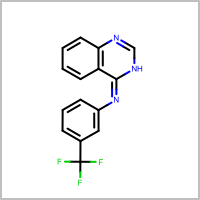

In [2]:
can_iso_SMILES = "c1ccc2c(c1)/c(=N\c3cccc(c3)C(F)(F)F)/[nH]cn2"
mol = OEGraphMol()
OESmilesToMol(mol, can_iso_SMILES)
oenb.draw_mol(mol)

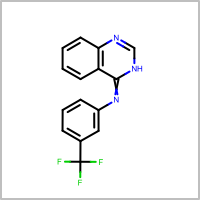

In [3]:
canonical_smiles = OECreateCanSmiString(mol)
mol2 = OEGraphMol()
OESmilesToMol(mol2, canonical_smiles)
oenb.draw_mol(mol2)

### Creating updated microstate list files with canonical SMILES for SAMPL6 repo

In [4]:
path_to_correction_files = "corrections_for_v1_4_2_cumulative/"
path_to_corrected_files = "microstate_lists_with_canonical_SMILES/"

# Iterate over 24 molecules
for j in range(24):
    mol_name = "SM"+str(j+1).zfill(2)
    print(mol_name, "...")

    # Read correction file
    correction_file = path_to_correction_files + mol_name + "_correction.csv"
    df_microstates = pd.read_csv(correction_file)

    # Convert all SMILES to canonical isomeric SMILES
    
    for i, row in enumerate(df_microstates.iterrows()):
        smiles = df_microstates.loc[i,"canonical isomeric SMILES"]

        mol = OEGraphMol()
        OESmilesToMol(mol, smiles)
        canonical_isomeric_smiles = OEMolToSmiles(mol)

        df_microstates.loc[i, "canonical isomeric SMILES"] = canonical_isomeric_smiles
    
    # Check if there is any deprecated microstate
    
    correction = df_microstates["correction"]
    deprecated_boolean = correction.isin(["deprecated"])

    deprecated_label = False
    for b in deprecated_boolean:
        if b == False:
            continue
        if b == True:
            print("Deprecated microstate found.")
            deprecated_label = True


    # Check if there is any added microstate

    correction = df_microstates["correction"]
    added_boolean = correction.isin(["added"])

    added_label = False
    for b in added_boolean:
        if b == False:
            continue
        if b == True:
            print("Added microstate found.")
            added_label = True


    # Write deprecated microstates to a separate file

    if(deprecated_label):
        df_deprecated = df_microstates.loc[df_microstates["correction"] == "deprecated"]
        print("Number of deprecated microstates of {}: {}".format(mol_name, df_deprecated.shape[0]))

        df_deprecated = df_deprecated.rename(columns = {"correction":"remarks"})

        deprecated_microstates_file_name = path_to_corrected_files + mol_name + "_microstates_deprecated.csv"
        df_deprecated.to_csv(deprecated_microstates_file_name, index=False)
        print("Created:" , deprecated_microstates_file_name)
        print("\n")


    # Write new microstates list with deprecated microstates removed and new microstates added.

    if(deprecated_label and added_label):
        df_remaining = df_microstates.loc[df_microstates["correction"] != "deprecated"]
        df_remaining = df_remaining.loc[df_remaining["correction"] != "added"]
        print("Number of remaining microstates of {}: {}".format(mol_name, df_remaining.shape[0]))

        df_added = df_microstates.loc[df_microstates["correction"] == "added"]
        print("Number of new microstates of {}: {}".format(mol_name, df_added.shape[0]))
        
        df_updated = df_microstates.loc[df_microstates["correction"] != "deprecated"]
        print("Total number of microstates in updated list of {}: {}".format(mol_name, df_updated.shape[0]))

    elif(added_label): # no deprecated
        df_remaining = df_microstates.loc[df_remaining["correction"] != "added"]
        print("Number of remaining microstates of {}: {}".format(mol_name, df_remaining.shape[0]))

        df_added = df_microstates.loc[df_microstates["correction"] == "added"]
        print("Number of new microstates of {}: {}".format(mol_name, df_added.shape[0]))

        df_updated = df_microstates
        print("Total number of microstates in updated list of {}: {}".format(mol_name, df_updated.shape[0]))

    elif(deprecated_label): # no added

        df_updated = df_microstates.loc[df_microstates["correction"] != "deprecated"]
        print("Total number of microstates in updated list of {}: {}".format(mol_name, df_updated.shape[0]))

    else:
        df_updated = df_microstates
        print("No correction to microstate list.")
        print("Total number of microstates in updated list of {}: {}".format(mol_name, df_updated.shape[0]))


    df_updated = df_updated.loc[:,("microstate ID","canonical isomeric SMILES")]
    df_updated = df_updated.reset_index(drop=True)
    
    
    # Add canonical SMILES to df_updated and write SMXX_microstate.csv
    
    df_updated["canonical SMILES"] = None
    
    for i, row in enumerate(df_updated.iterrows()):
        can_iso_smiles = df_updated.loc[i,"canonical isomeric SMILES"]

        mol = OEGraphMol()
        OESmilesToMol(mol, can_iso_smiles)
        canonical_smiles = OECreateCanSmiString(mol)

        df_updated.loc[i, "canonical SMILES"] = canonical_smiles    
    

    updated_microstates_file_name = path_to_corrected_files + mol_name + "_microstates.csv"
    df_updated.to_csv(updated_microstates_file_name, index=False)
    print("Created:" , updated_microstates_file_name)
    print("\n")


    # Create Excel file with 2D depiction for updated microstates list

    # Organize colums to create csv input file for csv2xlsx.py script
    df_2D_input = pd.DataFrame()
    df_2D_input["Molecule"] = df_updated["canonical isomeric SMILES"]
    df_2D_input["Microstate ID"] = df_updated["microstate ID"]
    df_2D_input["microstate ID"] = df_updated["microstate ID"]
    df_2D_input["canonical isomeric SMILES"] = df_updated["canonical isomeric SMILES"]
    df_2D_input["canonical SMILES"] = df_updated["canonical SMILES"]

    csv_file_name = path_to_corrected_files + "{}_microstate_IDs_with_2D_depiction.csv".format(mol_name)
    xlsx_file_name = path_to_corrected_files + "{}_microstate_IDs_with_2D_depiction.xlsx".format(mol_name)

    df_2D_input.to_csv(csv_file_name, index=False)

    !python csv2xlsx.py $csv_file_name $xlsx_file_name
    !trash $csv_file_name
    print("Created: ",xlsx_file_name)
    print(mol_name, ": Done!")
    print("\n")

SM01 ...
Deprecated microstate found.
Deprecated microstate found.
Number of deprecated microstates of SM01: 2
Created: microstate_lists_with_canonical_SMILES/SM01_microstates_deprecated.csv


Total number of microstates in updated list of SM01: 8
Created: microstate_lists_with_canonical_SMILES/SM01_microstates.csv


Created:  microstate_lists_with_canonical_SMILES/SM01_microstate_IDs_with_2D_depiction.xlsx
SM01 : Done!


SM02 ...
Deprecated microstate found.
Deprecated microstate found.
Deprecated microstate found.
Added microstate found.
Added microstate found.
Added microstate found.
Number of deprecated microstates of SM02: 3
Created: microstate_lists_with_canonical_SMILES/SM02_microstates_deprecated.csv


Number of remaining microstates of SM02: 8
Number of new microstates of SM02: 3
Total number of microstates in updated list of SM02: 11
Created: microstate_lists_with_canonical_SMILES/SM02_microstates.csv


Created:  microstate_lists_with_canonical_SMILES/SM02_microstate_IDs_with



Created:  microstate_lists_with_canonical_SMILES/SM15_microstate_IDs_with_2D_depiction.xlsx
SM15 : Done!


SM16 ...
No correction to microstate list.
Total number of microstates in updated list of SM16: 8
Created: microstate_lists_with_canonical_SMILES/SM16_microstates.csv


Created:  microstate_lists_with_canonical_SMILES/SM16_microstate_IDs_with_2D_depiction.xlsx
SM16 : Done!


SM17 ...
Deprecated microstate found.
Deprecated microstate found.
Deprecated microstate found.
Added microstate found.
Added microstate found.
Added microstate found.
Added microstate found.
Added microstate found.
Added microstate found.
Number of deprecated microstates of SM17: 3
Created: microstate_lists_with_canonical_SMILES/SM17_microstates_deprecated.csv


Number of remaining microstates of SM17: 2
Number of new microstates of SM17: 6
Total number of microstates in updated list of SM17: 8
Created: microstate_lists_with_canonical_SMILES/SM17_microstates.csv


Created:  microstate_lists_with_canonical_S